### Evaluate a polynomial string

In [1]:
def symbolize(s):
    """
    Converts a a string (equation) to a SymPy symbol object
    """
    from sympy import sympify
    s1=s.replace('.','*')
    s2=s1.replace('^','**')
    s3=sympify(s2)
    
    return(s3)

In [2]:
def eval_multinomial(s,vals=None,symbolic_eval=False):
    """
    Evaluates polynomial at vals.
    vals can be simple list, dictionary, or tuple of values.
    vals can also contain symbols instead of real values provided those symbols have been declared before using SymPy
    """
    from sympy import Symbol
    sym_s=symbolize(s)
    sym_set=sym_s.atoms(Symbol)
    sym_lst=[]
    for s in sym_set:
        sym_lst.append(str(s))
    sym_lst.sort()
    if symbolic_eval==False and len(sym_set)!=len(vals):
        print("Length of the input values did not match number of variables and symbolic evaluation is not selected")
        return None
    else:
        if type(vals)==list:
            sub=list(zip(sym_lst,vals))
        elif type(vals)==dict:
            l=list(vals.keys())
            l.sort()
            lst=[]
            for i in l:
                lst.append(vals[i])
            sub=list(zip(sym_lst,lst))
        elif type(vals)==tuple:
            sub=list(zip(sym_lst,list(vals)))
        result=sym_s.subs(sub)
    
    return result

### Helper function for flipping binary values of a _ndarray_

In [3]:
def flip(y,p):
    import numpy as np
    lst=[]
    for i in range(len(y)):
        f=np.random.choice([1,0],p=[p,1-p])
        lst.append(f)
    lst=np.array(lst)
    return np.array(np.logical_xor(y,lst),dtype=int)

### Classification sample generation based on a symbolic expression

In [4]:
def gen_classification_symbolic(m=None,n_samples=100,n_features=2,flip_y=0.0):
    """
    Generates classification sample based on a symbolic expression.
    Calculates the output of the symbolic expression at randomly generated (Gaussian distribution) points and
    assigns binary classification based on sign.
    m: The symbolic expression. Needs x1, x2, etc as variables and regular python arithmatic symbols to be used.
    n_samples: Number of samples to be generated
    n_features: Number of variables. This is automatically inferred from the symbolic expression. So this is ignored 
                in case a symbolic expression is supplied. However if no symbolic expression is supplied then a 
                default simple polynomial can be invoked to generate classification samples with n_features.
    flip_y: Probability of flipping the classification labels randomly. A higher value introduces more noise and make
            the classification problem harder.
    Returns a numpy ndarray with dimension (n_samples,n_features+1). Last column is the response vector.
    """
    
    import numpy as np
    from sympy import Symbol,sympify
    
    if m==None:
        m=''
        for i in range(1,n_features+1):
            c='x'+str(i)
            c+=np.random.choice(['+','-'],p=[0.5,0.5])
            m+=c
        m=m[:-1]
    sym_m=sympify(m)
    n_features=len(sym_m.atoms(Symbol))
    evals=[]
    lst_features=[]
    for i in range(n_features):
        lst_features.append(np.random.normal(scale=5,size=n_samples))
    lst_features=np.array(lst_features)
    lst_features=lst_features.T
    for i in range(n_samples):
        evals.append(eval_multinomial(m,vals=list(lst_features[i])))
    
    evals=np.array(evals)
    evals_binary=evals>0
    evals_binary=evals_binary.flatten()
    evals_binary=np.array(evals_binary,dtype=int)
    evals_binary=flip(evals_binary,p=flip_y)
    evals_binary=evals_binary.reshape(n_samples,1)
    
    lst_features=lst_features.reshape(n_samples,n_features)
    x=np.hstack((lst_features,evals_binary))
    
    return (x)

In [5]:
x=gen_classification_symbolic(m='2*x1+3*x2+5*x3',n_samples=10,flip_y=0.0)

In [6]:
import pandas as pd
df=pd.DataFrame(x)

In [7]:
df

,0,1,2,3
0,-0.442614,-0.523797,2.300378,1.0
1,-0.463687,3.200522,4.309449,1.0
2,-2.580825,-2.606877,5.845246,1.0
3,0.888534,3.727563,-3.174944,0.0
4,-1.120233,-2.737827,-8.308171,0.0
5,-4.832498,-6.591497,5.565251,0.0
6,-2.326688,4.751803,3.309559,1.0
7,-1.213919,-10.209268,2.447471,0.0
8,-1.320891,0.770222,-8.735817,0.0
9,2.150437,6.061752,-6.733177,0.0


In [8]:
x=gen_classification_symbolic(m='12*x1/(x2+5*x3)',n_samples=10,flip_y=0.2)
df=pd.DataFrame(x)
df

,0,1,2,3
0,5.566707,7.645691,0.559811,1.0
1,-10.528796,2.241197,-4.216359,0.0
2,5.000866,0.615997,2.021055,1.0
3,2.919458,3.593280,0.498438,1.0
4,4.671159,-0.679506,-5.125242,1.0
5,-4.484902,-12.881067,2.340985,1.0
6,1.302499,-5.054502,-1.396578,0.0
7,-2.321861,-2.548314,2.881654,0.0
8,-7.021660,4.530175,2.701544,0.0
9,-9.778964,-0.132642,4.021956,0.0


### Regression sample generation based on a symbolic expression

In [9]:
def gen_regression_symbolic(m=None,n_samples=100,n_features=2,noise=0.0,noise_dist='normal'):
    """
    Generates regression sample based on a symbolic expression. Calculates the output of the symbolic expression 
    at randomly generated (drawn from a Gaussian distribution) points
    m: The symbolic expression. Needs x1, x2, etc as variables and regular python arithmatic symbols to be used.
    n_samples: Number of samples to be generated
    n_features: Number of variables. This is automatically inferred from the symbolic expression. So this is ignored 
                in case a symbolic expression is supplied. However if no symbolic expression is supplied then a 
                default simple polynomial can be invoked to generate regression samples with n_features.
    noise: Magnitude of Gaussian noise to be introduced (added to the output).
    noise_dist: Type of the probability distribution of the noise signal. 
    Currently supports: Normal, Uniform, t, Beta, Gamma, Poission, Laplace

    Returns a numpy ndarray with dimension (n_samples,n_features+1). Last column is the response vector.
    """
    
    import numpy as np
    from sympy import Symbol,sympify
    
    if m==None:
        m=''
        for i in range(1,n_features+1):
            c='x'+str(i)
            c+=np.random.choice(['+','-'],p=[0.5,0.5])
            m+=c
        m=m[:-1]
    
    sym_m=sympify(m)
    n_features=len(sym_m.atoms(Symbol))
    evals=[]
    lst_features=[]
    
    for i in range(n_features):
        lst_features.append(np.random.normal(scale=5,size=n_samples))
    lst_features=np.array(lst_features)
    lst_features=lst_features.T
    lst_features=lst_features.reshape(n_samples,n_features)
    
    for i in range(n_samples):
        evals.append(eval_multinomial(m,vals=list(lst_features[i])))
    
    evals=np.array(evals)
    evals=evals.reshape(n_samples,1)
    
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0,scale=1.0,size=n_samples)
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0,high=1.0,size=n_samples)
    elif noise_dist=='beta':
        noise_sample=noise*np.random.beta(a=0.5,b=1.0,size=n_samples)
    elif noise_dist=='Gamma':
        noise_sample=noise*np.random.gamma(shape=1.0,scale=1.0,size=n_samples)
    elif noise_dist=='laplace':
        noise_sample=noise*np.random.laplace(loc=0.0,scale=1.0,size=n_samples)
        
    noise_sample=noise_sample.reshape(n_samples,1)
    evals=evals+noise_sample
        
    x=np.hstack((lst_features,evals))
    
    return (x)

#### Generate samples with a rational function as input 
### $$\frac{10x_1}{(3x_2+4x_3)}$$

In [10]:
x=gen_regression_symbolic(m='10*x1/(3*x2+4*x3)',n_samples=10,noise=0.1)
df=pd.DataFrame(x)
df

,0,1,2,3
0,-7.08499,-4.35839,8.10732,-3.67783156896633
1,-10.6684,0.779056,-6.64651,4.45796155973331
2,-6.69542,-5.307,1.17935,5.95108211351032
3,-3.83581,6.46401,-5.99678,8.28104884665168
4,-1.50995,-1.46056,-4.10213,0.493224249022704
5,2.22995,-1.12163,4.41009,1.51213441402200
6,4.26261,0.982687,7.0676,1.31581579041464
7,0.787195,2.20071,-4.68889,-0.724650906335961
8,0.720728,-2.32469,-0.468637,-0.917106940761226
9,-3.04485,-3.26701,-3.19083,1.40239700700260


#### Generate samples with no symbolic input and with 10 features

In [11]:
x=gen_regression_symbolic(n_features=10,n_samples=10,noise=0.1)
df=pd.DataFrame(x)
df

,0,1,2,3,4,5,6,7,8,9,10
0,-3.55302,-3.60695,-10.0729,7.85252,-3.76276,7.78251,-0.638193,-4.75034,-0.989603,0.181414,-10.2675547899900
1,-6.34778,-2.74753,-4.75187,4.70489,2.70014,5.29475,-0.190095,4.85289,-4.50207,-1.22839,-1.93507315813350
2,2.15057,-0.43572,-5.47805,6.96074,3.10096,-1.50898,1.09913,4.73097,-0.216513,-3.25629,4.91632094325713
3,1.11181,5.62156,0.0660036,6.66565,1.88656,-4.57167,-0.84389,-2.44545,1.66649,7.36169,18.0607243993836
4,-3.27857,-4.13545,4.36299,-3.73405,-1.3958,-6.39237,1.99202,-0.216661,-10.3905,3.43896,-23.7181534803553
5,-6.78726,-7.76895,-2.2653,-3.4326,-16.8937,-1.79111,4.79866,-4.43692,2.01342,-3.46766,-49.7886776301048
6,1.66157,-4.34424,6.69391,-3.42321,-8.63976,0.862722,2.70897,-13.5047,-7.14555,-3.16143,-33.7432854958296
7,3.46949,7.11633,-1.08523,6.41709,-1.23161,7.07956,6.6377,6.06688,-4.99262,3.85005,19.9862211512126
8,1.13155,4.02597,-3.05607,4.9271,-3.60454,6.06252,0.936673,4.07096,-2.04052,5.11093,15.8002295267657
9,-1.6051,4.97768,-7.69743,-0.65865,4.07053,2.98333,-10.9341,4.9402,2.9771,0.68357,21.5880195549236


In [12]:
import matplotlib.pyplot as plt

#### Generate samples with less noise and plot: $0.2x^2+1.2x+6+f_{noise}(x\mid{N=0.1})$

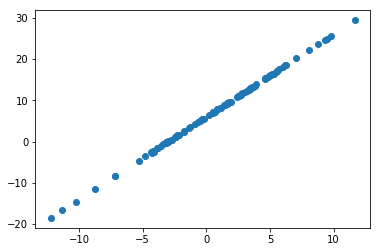

In [13]:
x=gen_regression_symbolic(m='0.2*x**2+1.2*x+6',n_samples=100,noise=0.1)
df=pd.DataFrame(x)
plt.scatter(df[0],df[1])
plt.show()

#### Generate samples with more noise and plo: $0.2x^2+1.2x+6+f_{noise}(x\mid{N=10})$

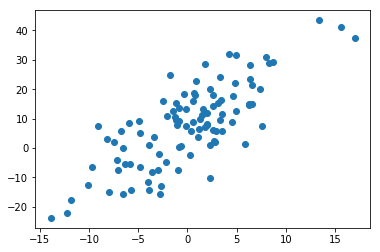

In [14]:
x=gen_regression_symbolic(m='0.2*x**2+1.2*x+6',n_samples=100,noise=10)
df=pd.DataFrame(x)
plt.scatter(df[0],df[1])
plt.show()

#### Generate samples with larger coefficent for the quadratic term and plot: $1.3x^2+1.2x+6+f_{noise}(x\mid{N=10})$

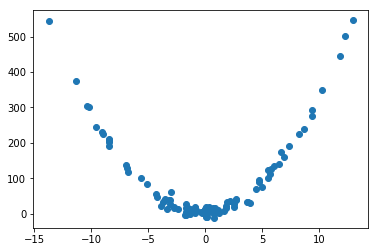

In [15]:
x=gen_regression_symbolic(m='1.3*x**2+1.2*x+6',n_samples=100,noise=10)
df=pd.DataFrame(x)
plt.scatter(df[0],df[1])
plt.show()